# Model Selection

In [96]:
import pandas as pd
from salmon import *
%matplotlib inline
plt.style.use('seaborn')
ames = pd.read_csv("data/chapter6/AmesHousing.txt")


With real data, we are usually given a data set with a wide array of variables. Most of the time, fitting a regression model using all of the variables will result in a bad model. Fortunately, we have a few methods that will help us choose which variables and models are the best. 
### Mallow's Criteron
Mallow's criteron is a popular method for finding the best linear regression model. The algorithm is as follows:
- For each subset of p - 1 variables:
    - Calculate Mallow's Criteron as: $C_p = \frac{SSE_p}{MSE_{full}} - (n-2p)$
    - If $C_p$ is less than or equal to p then the model is good.
    
   
Let's calculate one example of Mallow's Criteron using the Ames housing data set and SALMON.

In [4]:
lot_shape = C("Lot Shape")
bath = Q("Full Bath")
half_bath = Q("Half Bath")
living_area = Q("Gr Liv Area")
explanatory = living_area + lot_shape + bath + half_bath
response = Log(Q("SalePrice"))
model = LinearModel(explanatory, response)
model.fit(ames);
p = 5
n = len(ames)
mse = model.get_sse() / (n - p)
C_p = model.get_sse()/mse - (n - 2*p)
C_p, C_p <= p

(5.0, True)

From this individual Mallow's criteron, we can say that this is a "good" model. Now, we would calculate Mallow's criteron for all subsets and compare them to each other.

## Outliers, Influence, and Leverage
Just like when we started these notebooks, looking at your data is essential. One thing to look for immediately is outliers. Let's take a look at our ames housing dataset.

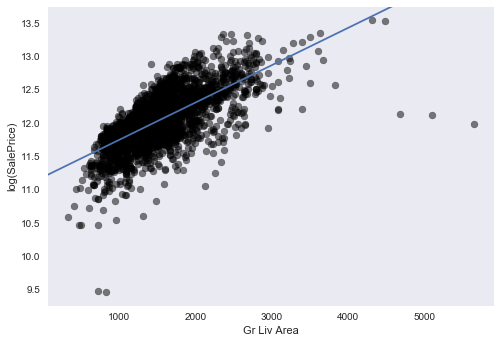

In [5]:
#lot_shape = C("Lot Shape")
living_area = Q("Gr Liv Area")
explanatory = living_area 
response = Log(Q("SalePrice"))
model = LinearModel(explanatory, response)
model.fit(ames)
model.plot(original_y_space=False)

Look at the plot, we can notice that there are three points that stand out away from the rest of the group. There are three homes with a sales price below $300,000 dollars and a living area larger than 4,200 sqft. This could be due to data entry or some unknown factor not recorded in the data. What we want to know is if it is an outlier in the X direction, Y direction, or both. Additionally, we want to check how much these points influence our model. If these points are dragging our regression toward them a significant amount, we can consider these points __influential__. Let's fit the model without these points and plot our regression lines again.

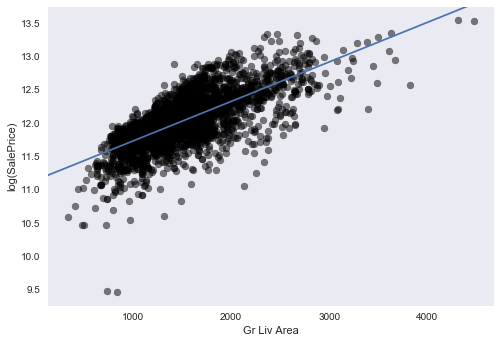

In [6]:
possible_outliers = ames[(ames["Gr Liv Area"] > 4200) & (ames["SalePrice"] < 300000)].index
without_outliers_data = ames.drop(possible_outliers)
model.fit(without_outliers_data)
model.plot(original_y_space=False)

From the plots, it is hard to confidently tell if the suspected outlier points have an influence at all on our model. First, let's check if any of these points are outliers in X. We can measure the distance from the center of the X, this is called leverage. A great way to check this is to calculate a Hat Matrix (H): $X(X^`X)^{-1}X$ and look at the diagonal (h).

In [60]:
X = ames.copy()
X["intercept"] = 1
X = X[["Gr Liv Area", "intercept"]]
h = np.diag(X.dot(np.linalg.inv(X.T.dot(X)).dot(X.T)))

Once we have the diagonal, for the i-th point we can compare $h_{ii}$ to $\bar{h}$. The point has high leverage if $h_{ii}$ < $2\bar{h}$. The i values for our potential outliers are 1498, 2180, and 2181. Let's check there value in `h` and compare them against $\bar{h}$. 

In [61]:

outlier_1 = h[possible_outliers[0]]
outlier_2 = h[possible_outliers[1]]
outlier_3 = h[possible_outliers[2]]
h_bar = 1.0/len(ames)
outlier_1, outlier_1 < 2*h_bar, outlier_2, outlier_2 < 2*h_bar, outlier_3, outlier_3 < 2*h_bar

(0.023266233300905263,
 False,
 0.017611427284564447,
 False,
 0.013820638539492763,
 False)

From the output above, we can confidently confirm that the three suspected points have low leverage and are not outliers in the X direction. Though from the plots, what's curious is that the three plots are so low in price for their size. To check if a point is an outlier in the Y direction we can use standardize deleted residuals. Standardized deleted residuals are calculated in the following way: 
$$t_i = \frac{e_i}{\sqrt{MSE_i(1-h_{ii})}}$$
Where $MSE_i$ is the MSE without the ith value. Let's caculate the standardized deleted residual with one of the variables. We will use the h matrix calculated above.

In [91]:
model.fit(ames)
p = 2
e_i = model.residuals.iloc[possible_outliers[0]]
new_fitted = model.fitted.drop(possible_outliers[0]).iloc[:,0]
new_y = model.training_y.drop(possible_outliers[0]).iloc[:,0]
sse = ((new_y - new_fitted) ** 2).sum()
mse = sse / (len(ames) - 1 - p)
h_ii = h[possible_outliers[0]]
t_i = e_i/np.sqrt((mse*(1-h_ii)))
t_i

Residuals   -8.254738
Name: 1498, dtype: float64

After we calculate our studentized deleted residual, we can compare against a t distribution to check if the point is a significant outlier. Formally the test is:
$$|t_i| > t(1-\alpha/2p, n-p-1)$$
From a t-table, we can say the t_i is larger than the test statistic and the point is an outlier in the Y direction.

Another metric we can use to calculate the influence of a point is Cook's Distance. Cook's Distance depends on both leverage and the residuals. This metric materializes how much influence a point has on the least squares function when included.  With high values of Cook's Distance, the point has higher influence. Let's calculate the Cook's distance for a different suspected outlier. $$D_i = t_i = \frac{e_i^2}{p*MSE_i}* \frac{h_{ii}}{(1-h_{ii})^2}$$

In [95]:
p = 2
e_i = model.residuals.iloc[possible_outliers[1]]
fitted = model.fitted.iloc[:,0]
y = model.training_y.iloc[:,0]
sse = ((y - fitted) ** 2).sum()
mse = sse / (len(ames) - 1 - p)
h_ii = h[possible_outliers[1]]
D_i = (e_i**2/(p*mse)) * (h_ii/(1-h_ii)**2)
D_i

Residuals    0.390776
Name: 2180, dtype: float64

To measure the influence using cook's distance:
- if our $D_i$ < the 20th percentile of the F(p, n - p) distribution, then case i has little influence on the fitted values.
- if our $D_i$ > the 20th percentile and < the 50th percentile of the F(p, n - p) distribution, then case i has moderate influence on the fitted values.
- if our $D_i$ > the 50th percentile of the F(p, n - p) distribution, then case i has little influence on the large values.

With our cook's distance the 20th and 50th percentiles are roughly 0.223 and 0.693, meaning that our point has moderate influence on our fitted values.
